In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
# -------------------- Parameters --------------------
N = 100         # Lattice size (NxN grid)
J = 1          # Interaction strength (ferromagnetic)
k_B = 1         # Boltzmann constant
STEPS = 500_000  # Total Monte Carlo steps for Problem A
BURNIN = 50_000  # Burn-in period (initial steps discarded)
B = 0


In [3]:
# -------------------- Compute Energy --------------------
def compute_energy(lattice):
    #Compute total energy of the Ising lattice.
    energy = 0
    N = lattice.shape[0]
    for i in range(N):
        for j in range(N):
            for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:  # Nearest neighbors
                i_neigh = (i + k) % N  # Periodic BC
                j_neigh = (j + l) % N
                energy += -J * 1/2 *lattice[i, j] * lattice[i_neigh, j_neigh] - B * lattice[i, j]
    return energy # Avoid double-counting


In [4]:
# -------------------- Metropolis Algorithm --------------------
def metropolis(lattice, T, B, steps):
    # Returns magnetization values over time.
    N = lattice.shape[0]
    magnetization = []  # Track magnetization over time
    num_accept = 0  # Count accepted flips

    for _ in tqdm.tqdm(range(steps)):
        i, j = np.random.randint(N), np.random.randint(N)  # Pick random spin
        delta_E = 0

        # Compute energy change ΔE if flipping spin (i, j)
        for k, l in [(-1, 0), (1, 0), (0, 1), (0, -1)]:  # Nearest neighbors
            i_neigh = (i + k) % N
            j_neigh = (j + l) % N
            delta_E += -J * -2 * lattice[i, j] * lattice[i_neigh, j_neigh] - B * lattice[i, j]

        # Metropolis acceptance rule
        if delta_E <= 0 or np.random.random() < np.exp(-delta_E / (k_B * T)):
            lattice[i, j] *= -1  # Flip spin
            num_accept += 1

        # Track magnetization per spin
        magnetization.append(np.mean(lattice))

    acceptance_rate = num_accept / steps
    print(f"Acceptance rate at T={T}: {acceptance_rate:.4f}")
    return magnetization


In [5]:
# -------------------- Problem A: Magnetization vs. Steps (T = 2) --------------------
# Run for both initial configurations
def initialize_lattice(N, mode="ordered"):
    # Initialize a NxN Ising lattice.
    # mode="ordered": All spins +1
    # mode="random": Spins randomly +1 or -1
    if mode == "ordered":
        return np.ones((N, N))
    elif mode == "random":
        return np.random.choice([-1, 1], size=(N, N))

lattice_ordered = initialize_lattice(N, mode="ordered")
lattice_random = initialize_lattice(N, mode="random")

T_vals = np.linspace(1, 3, 50)
B_vals = np.linspace(-1, 1, 50)

M = np.zeros((len(T_vals),len(B_vals)))

import os

if os.path.exists("magnetization_data.npy"):
    os.remove("magnetization_data.npy")
    print("Deleted old magnetization data.")
else:
    M = np.zeros((len(T_vals), len(B_vals)))
    
    for i, T in enumerate(T_vals):
        for j, B in enumerate(B_vals):
            m_random = metropolis(lattice_random, T, B, STEPS)
            m_mean_random = np.mean(m_random[BURNIN:])
            M[j, i] = m_mean_random
            print(f"Mean magnetization (Random)  = {m_mean_random:.4f}")

    np.save("magnetization_data.npy", M)  # Save after computing
    print("Saved new magnetization data.")


100%|██████████| 500000/500000 [00:18<00:00, 27181.26it/s]


Acceptance rate at T=1.0: 0.0128
Mean magnetization (Random)  = 0.9997


100%|██████████| 500000/500000 [00:18<00:00, 27217.78it/s]


Acceptance rate at T=1.0: 0.0000
Mean magnetization (Random)  = 1.0000


 40%|████      | 201310/500000 [00:07<00:11, 27028.00it/s]


KeyboardInterrupt: 

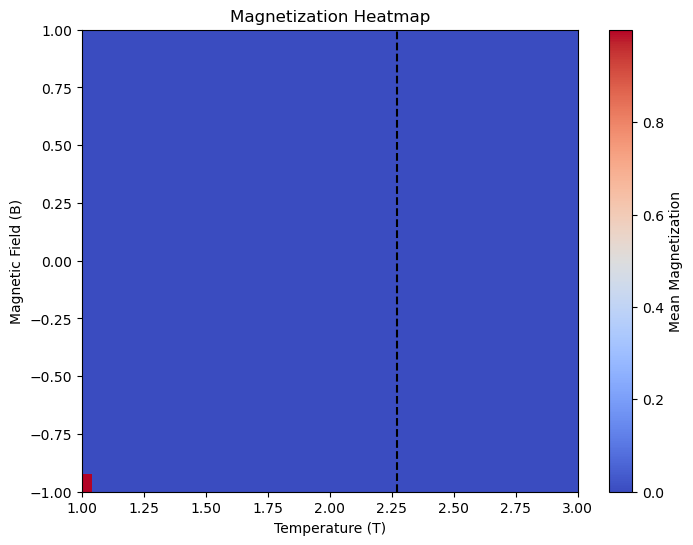

In [6]:
# --------------- PLOT ----------------

plt.figure(figsize=(8, 6))
plt.imshow(M, aspect="auto", cmap="coolwarm", origin="lower", 
           extent=[T_vals.min(), T_vals.max(), B_vals.min(), B_vals.max()])

# Add a vertical line at T = 2.269
plt.axvline(x=2.269, color='black', linestyle='--', label=r"$T_c = 2.269$")


plt.colorbar(label="Mean Magnetization")
plt.ylabel("Magnetic Field (B)")
plt.xlabel("Temperature (T)")
plt.title("Magnetization Heatmap")

plt.show()